# Vision Transformer Model Details:

**Architecture:** Vision Transformer (ViT)

**Input:** Mel Spectrograms of audio files

**Model components:**

Patch Embedding: Conversion of input spectrograms into patches for processing by the transformer.

Positional Encoding: Addition of positional information to the input patches to capture spatial relationships.

Transformer Layers: Stacked transformer layers that enable self-attention and feature extraction.

Global Average Pooling: Aggregation of spatial information across the patches.
Classification Layer: Dense layer with softmax activation for predicting the music genre.

**Hyperparameters:**

Patch Size: The size of the patches used for processing.

Embedding Dimension: The dimensionality of the patch embeddings.

Number of Attention Heads: The number of parallel attention heads in the transformer.

MLP Dimension: The dimensionality of the multi-layer perceptron (MLP) in the transformer.

Number of Transformer Layers: The depth of the transformer network.
Training:

Optimizer: Adam optimizer with a learning rate of 1e-3.

Loss Function: categorical cross-entropy loss for multi-class classification.

Evaluation Metric: Accuracy.

**Challenges and Improvements needed:**

Limited labeled data: Discuss the potential for transfer learning or data augmentation techniques to mitigate the data scarcity issue.

Hyperparameter tuning: Mention the importance of conducting thorough hyperparameter search to optimize model performance.


**Transformer encoder** consists of alternating layers of multi-headed self-attention and MLP blocks. Layer-norm (LN) is applied before every block, and residual connections after every block.

**Attention**
The attention mechanism takes three inputs: queries, keys and values. It computes the attention matrix with these.

We have multi-head attention mechanism, the computation will be split across multiple heads with a smaller input size.

The product between the queries and the keys gives an understanding of how much each element in a sequence is important to the rest. This information is later used to scale the values.

# Instructions to run the notebook

1. Download the GTZAN dataset from https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
2. Upload it into your drive. (Create a folder in your drive and upload the folder downloaded here. It should have the folder "Data" which contains images_original, genres_original, features_3_sec.csv and features_30s.csv)

3. Use the correct link to your drive in the required cells.

# Importing libraries and mounting drive to get data

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing all libraries
import os
import math
import librosa
import numpy as np
from PIL import Image
from IPython.display import display
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LayerNormalization,
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from google.colab import drive, auth
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Mounting Google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# To check if using Google Colab Pro High RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
# Processing the Kaggle dataset
base_path = "/content/drive/My Drive/DS 5500" # Replace with your folder path
folder_path = f'{base_path}/Data/genres_original'
files = os.listdir(folder_path)
labels = []

for file in files:
    labels.append(file)

song_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/genres_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  song_dct[label] = files

images_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/images_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  images_dct[label] = files

In [6]:
song_dct.keys()

dict_keys(['hiphop', 'rock', 'reggae', 'country', 'classical', 'metal', 'jazz', 'disco', 'blues', 'pop'])

# Convert to Spectrograms

Some files are corrupted and they are avoided.

## Method 1 - Using 30 seconds duration clips

In [15]:
# Prepare empty dictionaries to store the Mel spectrograms and rejected files
mel_spectrograms = {}
rejected_files = {}

for label, files in song_dct.items():
    mel_spectrograms[label] = []  # Initialize empty list for this label
    for file in files:
        # Construct full file path
        file_path = f'/content/drive/My Drive/DS 5500/Data/genres_original/{label}/{file}'

        try:
            # Load audio file
            y, sr = librosa.load(file_path)
            y, _ = librosa.effects.trim(y)

            # num_channels = y.ndim
            # # Get the sampling rate
            # sampling_rate = librosa.get_samplerate(file_path)
            # duration = len(y) / sampling_rate
            # # 1 channel y.shape - (661504,), Sampling rate: 22050, Duration: 30.00018140589569
            # print(num_channels, y.shape)
            # print("Sampling rate:", sampling_rate)
            # print("Duration:", duration)

            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

            # Convert to log scale
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

            # Append log Mel spectrogram to list for this label
            mel_spectrograms[label].append(log_mel_spectrogram)
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")
            if label in rejected_files:
                rejected_files[label].append(file_path)
            else:
                rejected_files[label] = [file_path]

print(f"Processed files. {len(rejected_files)} files were rejected.")

<ipython-input-15-9bcd2809a3bc>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00054.wav: 
Processed files. 1 files were rejected.


## Method 2 - 30 second original audio clips segmented to 3 second audio clips

In [8]:
# clip_duration = 3  # Duration of each clip in seconds

# # Prepare empty dictionaries to store the Mel spectrograms and rejected files
# mel_spectrograms = {}
# rejected_files = {}

# for label, files in song_dct.items():
#     mel_spectrograms[label] = []  # Initialize empty list for this label
#     for file in files:
#         # Construct full file path
#         file_path = f'/content/drive/My Drive/DS 5500/Data/genres_original/{label}/{file}'

#         try:
#             # Load audio file
#             y, sr = librosa.load(file_path)
#             y, _ = librosa.effects.trim(y)

#             # Calculate the number of samples in each clip
#             clip_samples = int(sr * clip_duration)

#             # Calculate the number of clips
#             num_clips = math.ceil(len(y) / clip_samples)

#             # Split the audio into clips
#             for i in range(num_clips):
#                 start_sample = i * clip_samples
#                 end_sample = start_sample + clip_samples

#                 # Check if the end sample exceeds the length of the audio
#                 if end_sample > len(y):
#                     clip = np.pad(
#                         y[start_sample:], (0, end_sample - len(y)), mode='constant'
#                     )
#                 else:
#                     clip = y[start_sample:end_sample]

#                 # Compute Mel spectrogram for the clip
#                 mel_spectrogram = librosa.feature.melspectrogram(y=clip, sr=sr)

#                 # Convert to log scale
#                 log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

#                 # Append log Mel spectrogram to list for this label
#                 mel_spectrograms[label].append(log_mel_spectrogram)
#         except Exception as e:
#             print(f"Could not process file {file_path}: {e}")
#             if label in rejected_files:
#                 rejected_files[label].append(file_path)
#             else:
#                 rejected_files[label] = [file_path]

# print(f"Processed files. {len(rejected_files)} files were rejected.")

## Inspecting size of mel spectrogram

Shape of each mel spectrogram is (128, 130) for 3 second segment.

Shape of each mel spectrogram is (128, 1293) for 30 second original clip.

In [16]:
print(mel_spectrograms['pop'][0].shape)

(128, 1293)


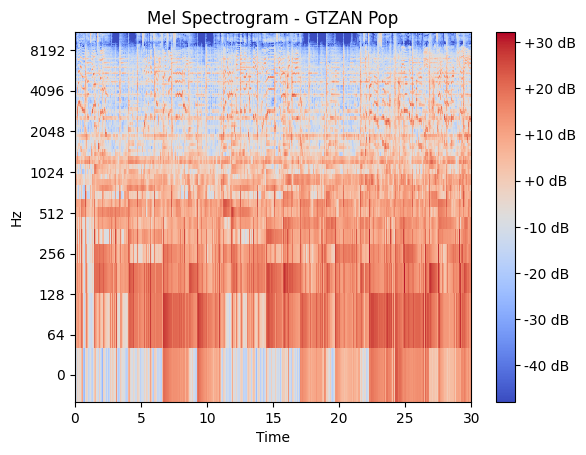

In [17]:
# Display spectrogram
librosa.display.specshow(mel_spectrograms['pop'][0], sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram - GTZAN Pop')
plt.show()

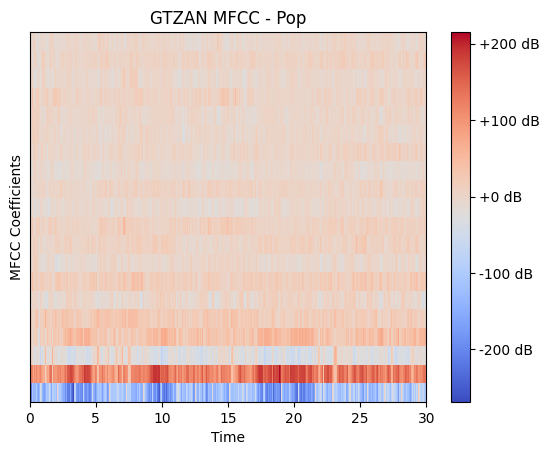

In [12]:
# Visualize MFCC
y, sr = librosa.load('/content/drive/My Drive/DS 5500/Data/genres_original/pop/' + song_dct['pop'][0])
y, _ = librosa.effects.trim(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr)

# Display MFCC
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('GTZAN MFCC - Pop')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

# Converting mel spectrograms into images for the model training

## Method 1 - Using RGB images

In [18]:
# Set the desired image size
image_size = (128, 128)  # Adjust the size based on your model's input size

# Prepare empty dictionary to store converted spectrograms
converted_spectrograms = {}

# Convert spectrograms to image-like format
for label, spectrograms in mel_spectrograms.items():
    converted_spectrograms[label] = []  # Initialize empty list for this label
    for spectrogram in spectrograms:
        # Create an Image object from the spectrogram
        spectrogram_image = Image.fromarray(spectrogram)

        # Resize the image to the desired size
        resized_image = spectrogram_image.resize(image_size)

        # # Convert the image to RGB format
        rgb_image = resized_image.convert("RGB")

        # Convert the image to a tensor and normalize its values
        tensor_image = tf.convert_to_tensor(rgb_image, dtype=tf.float32)

        # Normalize the tensor image
        min = tf.reduce_min(tensor_image)
        max = tf.reduce_max(tensor_image)
        mean = tf.reduce_mean(tensor_image)
        std = tf.math.reduce_std(tensor_image)
        # print("Minimum, maximum pixel value, mean, std:", min, max, mean, std)
        normalized_tensor_image = (tensor_image - min) / (max - min)
        # normalized_tensor_image = (tensor_image - mean) / std

        # Append the tensor representation to the list for this label
        converted_spectrograms[label].append(normalized_tensor_image)

In [19]:
min_val = tf.reduce_min(tf.concat([tensor for tensors in converted_spectrograms.values() for tensor in tensors], axis=0))
max_val = tf.reduce_max(tf.concat([tensor for tensors in converted_spectrograms.values() for tensor in tensors], axis=0))
print(min_val, max_val)

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## Grayscale Version

In [78]:
# # Define target image dimensions
# image_width = 64
# image_height = 64
# num_channels = 1

# # Prepare empty dictionary to store converted spectrograms
# converted_spectrograms = {}

# # Convert spectrograms to image-like format
# for label, spectrograms in mel_spectrograms.items():
#     converted_spectrograms[label] = []  # Initialize empty list for this label
#     for spectrogram in spectrograms:
#         # Normalize the spectrogram to [0, 1]
#         spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

#         # Convert the spectrogram array to uint8 data type
#         spectrogram_uint8 = (spectrogram_normalized * 255).astype(np.uint8)

#         # Create a PIL image from the spectrogram array
#         spectrogram_image = Image.fromarray(spectrogram_uint8)

#         # <class 'PIL.Image.Image'> (1293, 128)
#         # print(type(spectrogram_image), spectrogram_image.size)
#         # mode = spectrogram_image.mode
#         # bands = spectrogram_image.getbands()
#         # num_channels = len(bands)
#         # print("Number of channels:", len(mode))
#         # print("Number of channels:", num_channels)

#         # Convert the image to grayscale
#         spectrogram_image_gray = spectrogram_image.convert('L')

#         # Resize the image
#         image = spectrogram_image.resize((image_width, image_height))

#         # Convert the image to a NumPy array
#         image_array = np.array(image)

#         # Normalize the pixel values to [0, 1]
#         image_array_normalized = image_array / 255.0

#         # Add an extra dimension for the batch size
#         image_array = tf.expand_dims(image_array_normalized, axis=-1)

#         # Convert the array to a TensorFlow tensor
#         image_tensor = tf.convert_to_tensor(image_array)

#         converted_spectrograms[label].append(image_tensor)

## Using mel spectrograms given in Kaggle dataset

In [ ]:
# #  Using existing sepctrogram images in Kaggle dataset

# # Set the desired image size
# image_size = (224, 224)

# base_path = "/content/drive/My Drive/DS 5500"
# folder_path = f'{base_path}/Data/images_original'  # Replace with the path to your spectrogram images folder
# labels = os.listdir(folder_path)

# converted_spectrograms = {}

# for label in labels:
#     label_folder = os.path.join(folder_path, label)
#     files = os.listdir(label_folder)
#     converted_spectrograms[label] = []  # Initialize empty list for this label

#     for file in files:
#         image_path = os.path.join(label_folder, file)
#         image = Image.open(image_path)
#         # # Image size is initially (432, 288)
#         # print(image.size)
#         # Remove alpha channel if it exists
#         if image.mode == 'RGBA':
#             image = image.convert('RGB')

#         rgb_image = image.resize(image_size)  # Resize to desired dimensions

#         # Convert the image to a tensor and normalize its values
#         tensor_image = tf.convert_to_tensor(rgb_image, dtype=tf.float32)
#         # tensor_image = tf.convert_to_tensor(rgb_image)

#         # Normalize the tensor image
#         min = tf.reduce_min(tensor_image)
#         max = tf.reduce_max(tensor_image)
#         mean = tf.reduce_mean(tensor_image)
#         std = tf.math.reduce_std(tensor_image)
#         # print("Minimum, maximum pixel value, mean, std:", min, max, mean, std)

#         normalized_tensor_image = (tensor_image - min) / (max - min)
#         # normalized_tensor_image = (tensor_image - mean) / tf.maximum(std, 1e-8)

#         # Append the tensor representation to the list for this label
#         converted_spectrograms[label].append(normalized_tensor_image)

## Label Encoding

In [30]:
converted_spectrograms['jazz'][0].shape

TensorShape([128, 128, 3])

In [31]:
# from sklearn.preprocessing import MinMaxScaler

# Prepare empty lists to store the spectrograms and labels
X = []
y = []

# Iterate over the mel spectrograms
for label, spectrograms in converted_spectrograms.items():
    for spectrogram in spectrograms:
        X.append(spectrogram)
        y.append(label)

# Convert the lists to NumPy arrays
X = np.array(X)
y = np.array(y)
# X_normalized = (X - np.min(X)) / (np.max(X) - np.min(X))
# X = X_normalized

# # Reshape the input tensor to 2D for MinMaxScaler
# X_reshaped = X.reshape(X.shape[0], -1)

# # Create an instance of MinMaxScaler
# scaler = MinMaxScaler()

# # Fit and transform the input tensor using MinMaxScaler
# X_normalized = scaler.fit_transform(X_reshaped)

# # Reshape the normalized tensor back to its original shape
# X_normalized = X_normalized.reshape(X.shape)

# Perform label encoding and one-hot encoding
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y)
y_one_hot_encoded = to_categorical(y_label_encoded)

In [32]:
min_val = np.min(X)
max_val = np.max(X)
print(min_val, max_val)

0.0 1.0


# Vision Transformer Model

## Model Architecture 1

In [ ]:
# def create_vit_model(input_shape, num_classes):
#     # Vision Transformer parameters
#     patch_size = 12  # Size of the patches used for patch embedding
#     num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
#     embedding_dim = 128  # Dimensionality of the patch embeddings and positional encodings
#     num_heads = 8  # Number of attention heads in the multi-head attention mechanism
#     mlp_dim = 256  # Dimensionality of the feed-forward MLP layers in the transformer blocks
#     num_layers = 6  # Number of transformer blocks in the model
#     dropout_rate = 0.1

#     # Patch embedding layer
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(embedding_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
#     x = layers.Reshape((-1, embedding_dim))(x)

#     # Positional encoding
#     positions = np.arange(num_patches)
#     positional_encoding = position_embedding(positions, embedding_dim)
#     positional_encoding = tf.cast(positional_encoding, dtype=tf.float32)  # Convert to float32
#     positional_encoding = tf.reshape(positional_encoding, (-1, num_patches, embedding_dim))  # Reshape to match x shape
#     x += positional_encoding

#     # Transformer layers
#     for _ in range(num_layers):
#         x = transformer_block(x, embedding_dim, num_heads, mlp_dim)

#     # Global average pooling - to reduce the spatial dimensions of the output
#     x = layers.GlobalAveragePooling1D()(x)

#     # Final classification layer - softmax activation function is used to produce the final class probabilities
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     # Create the model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     return model

# # This function generates a positional encoding matrix based on the positions and embedding dimensions.
# # The positions are scaled by a factor based on the index and the embedding dimension.
# # The resulting matrix is then concatenated with sine and cosine functions of different frequencies.
# def position_embedding(positions, d_model):
#     angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
#     angle_rads = positions[:, np.newaxis] * angle_rates[np.newaxis, :]
#     sines = np.sin(angle_rads[:, 0:d_model//2])
#     cosines = np.cos(angle_rads[:, d_model//2:])
#     pos_encoding = np.concatenate([sines, cosines], axis=-1)
#     pos_encoding = pos_encoding[np.newaxis, ...]
#     pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
#     return pos_encoding

# # This function represents a single transformer block.
# # It takes the input x along with the embedding dimension, number of attention heads, and MLP dimension as arguments.
# # Within the block, it applies multi-head attention to the input tensor, followed by a residual connection, layer normalization, and a feed-forward MLP.
# # Another residual connection, layer normalization, and dropout are applied before returning the output.
# def transformer_block(x, embedding_dim, num_heads, mlp_dim):
#     # Multi-head attention
#     attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(x, x)
#     attention_output = layers.Dropout(0.1)(attention_output)
#     x1 = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

#     # MLP
#     mlp_output = layers.Dense(units=mlp_dim, activation='relu')(x1)
#     mlp_output = layers.Dense(units=embedding_dim)(mlp_output)
#     mlp_output = layers.Dropout(0.1)(mlp_output)
#     x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + mlp_output)

#     return x2

## Model Architecture 2

In [ ]:
# # Define the Vision Transformer model
# class VisionTransformer(keras.Model):
#     def __init__(
#         self,
#         in_channels=3,
#         patch_size=16,
#         emb_size=768,
#         img_size=356,
#         depth=12,
#         n_classes=10,
#         **kwargs
#     ):
#         super(VisionTransformer, self).__init__()
#         self.patch_embedding = layers.Conv2D(
#             filters=emb_size,
#             kernel_size=patch_size,
#             strides=patch_size,
#             padding="valid",
#             activation="linear",
#         )
#         self.transformer_encoder = TransformerEncoder(depth, emb_size=emb_size, **kwargs)
#         self.classification_head = ClassificationHead(emb_size, n_classes)

#     def call(self, inputs):
#         x = self.patch_embedding(inputs)
#         x = tf.reshape(x, (-1, x.shape[1] * x.shape[2], x.shape[3]))
#         x = self.transformer_encoder(x)
#         x = tf.reduce_mean(x, axis=1)
#         x = self.classification_head(x)
#         return x

# # Define the PatchEmbedding layer
# class PatchEmbedding(layers.Layer):
#     def __init__(self, in_channels, patch_size, emb_size, img_size):
#         super(PatchEmbedding, self).__init__()
#         self.patch_size = patch_size
#         self.img_size = img_size
#         self.num_patches = (img_size // patch_size) ** 2

#         self.projection = layers.Conv2D(emb_size, kernel_size=patch_size, strides=patch_size)

#     def call(self, inputs):
#         x = self.projection(inputs)
#         x = tf.reshape(x, (-1, self.num_patches, x.shape[3]))
#         return x

# def gelu(x):
#     return 0.5 * x * (1 + tf.math.erf(x / tf.sqrt(2.0)))

# class MLPBlock(layers.Layer):
#     def __init__(self, hidden_dim, mlp_dim, dropout=0.1):
#         super(MLPBlock, self).__init__()
#         self.mlp = keras.Sequential(
#             [
#                 layers.Dense(mlp_dim, activation=gelu),
#                 layers.Dropout(dropout),
#                 layers.Dense(hidden_dim),
#                 layers.Dropout(dropout),
#             ]
#         )

#     def call(self, inputs):
#         return self.mlp(inputs)

# # Define the TransformerEncoder layer
# class TransformerEncoder(layers.Layer):
#     def __init__(self, depth, emb_size, num_heads, mlp_dim, dropout=0.1):
#         super(TransformerEncoder, self).__init__()
#         self.depth = depth
#         self.multihead_attention = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=emb_size // num_heads, dropout=dropout
#         )
#         self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
#         self.mlp_block = MLPBlock(emb_size, mlp_dim)
#         self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
#         self.dropout = layers.Dropout(dropout)

#     def call(self, inputs):
#         x = inputs
#         for _ in range(self.depth):
#             attention = self.multihead_attention(x, x)
#             x = self.layer_norm1(x + attention)
#             x = self.mlp_block(x)
#             x = self.layer_norm2(x)
#         return x
# class ClassificationHead(layers.Layer):
#     def __init__(self, emb_size, n_classes):
#         super(ClassificationHead, self).__init__()
#         self.flatten = layers.Flatten()
#         self.fc1 = layers.Dense(emb_size, activation="relu")
#         self.dropout = layers.Dropout(0.5)
#         self.fc2 = layers.Dense(n_classes, activation="softmax")

#     def call(self, inputs):
#         x = self.flatten(inputs)
#         x = self.fc1(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

## Model Architecture 3

In [44]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        output = self.combine_heads(concat_attention)
        return output


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential(
            [
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(embed_dim),
                Dropout(dropout),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training):
        inputs_norm = self.layernorm1(inputs)
        attn_output = self.att(inputs_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = attn_output + inputs

        out1_norm = self.layernorm2(out1)
        mlp_output = self.mlp(out1_norm)
        mlp_output = self.dropout2(mlp_output, training=training)
        return mlp_output + out1

class VisionTransformer(tf.keras.Model):
    def __init__(
        self,
        image_size,
        patch_size,
        num_layers,
        num_classes,
        d_model,
        num_heads,
        mlp_dim,
        channels=3,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.d_model = d_model
        self.num_layers = num_layers

        self.rescale = Rescaling(1.0 / 255)
        self.pos_emb = self.add_weight(
            "pos_emb", shape=(1, num_patches + 1, d_model)
        )
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))
        self.patch_proj = Dense(d_model)
        self.enc_layers = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]
        self.mlp_head = tf.keras.Sequential(
            [
                LayerNormalization(epsilon=1e-6),
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(num_classes),
            ]
        )

    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        x = self.rescale(x)
        patches = self.extract_patches(x)
        x = self.patch_proj(patches)

        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb

        for layer in self.enc_layers:
            x = layer(x, training)

        # First (class token) is used for classification
        x = self.mlp_head(x[:, 0])
        return x

# Model Training

In [45]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

# Convert the NumPy arrays to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

print("X type and shape: ", type(X), X.shape)
print("y_one_hot_encoded and shape: ", type(y_one_hot_encoded), y_one_hot_encoded.shape)
print("X_train type and shape: ", type(X_train), X_train.shape)
print("X_val type and shape: ", type(X_val),X_val.shape)
print("y_train type and shape: ", type(y_val), y_train.shape)  # (number_of_samples, num_classes)
print("y_val type and shape: ", type(y_val), y_val.shape)  # (number_of_samples, num_classes)

X type and shape:  <class 'numpy.ndarray'> (999, 128, 128, 3)
y_one_hot_encoded and shape:  <class 'numpy.ndarray'> (999, 10)
X_train type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (799, 128, 128, 3)
X_val type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (200, 128, 128, 3)
y_train type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (799, 10)
y_val type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (200, 10)


In [46]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Data augmentation using ImageDataGenerator
# datagen = ImageDataGenerator(
#     rescale=1.0 / 255.0,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     rotation_range=10,
#     zoom_range=0.1
# )

## Training with Architecture 1

In [ ]:
# # Defining parameters
# input_shape = (128, 128, 3)  # Adjust the shape based on your spectrogram size
# num_classes = 10  # 10 genres
# model = create_vit_model(input_shape, num_classes)

## Training with Architecture 2

In [ ]:
# model = VisionTransformer(
#     in_channels=3,
#     patch_size=16,
#     emb_size=768,
#     img_size=356,
#     depth=12,
#     num_heads=8,  # Update with the desired number of heads
#     mlp_dim=1024,  # Update with the desired MLP dimension
#     n_classes=10
# )

TypeError: ignored

## Training with Architecture 3

In [47]:
model = VisionTransformer(
    image_size=128,
    num_classes=10,
    channels=3,
    dropout=0.3,
    patch_size=4, # 8-32
    num_layers=4, # 6-12
    d_model=512, #  128-1024
    num_heads=4, # 4-16
    mlp_dim=1024, #256-1024
)

In [48]:
# Tried multiple learning rates - 0.1, 0.01, 1e-3, 1e-4, 1e-5, 3e-4
adam_weight = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

# categorical cross entropy is labels are one hot encoded and from_logits=True since there is no softmax activation function in final layer
ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
    loss=ce_loss,
    optimizer=adam_weight,
    metrics=["accuracy"],
)

# Define early stopping and reduce LR callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, verbose=True)

In [ ]:
# To run the model with image augmentation - this did not produce good results
# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     validation_data=(X_val, y_val),
#     epochs=50,
#     callbacks=[early_stopping, lr_schedule],
# )

# Tried multiple batch sizes - 32, 64, 128 and multiple epochs - 30, 35, 50, 60, 100
history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_schedule])

Epoch 1/30


In [52]:
model.summary()

Model: "vision_transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     multiple                  0         
                                                                 
 dense_81 (Dense)            multiple                  25088     
                                                                 
 transformer_block_12 (Trans  multiple                 2102784   
 formerBlock)                                                    
                                                                 
 transformer_block_13 (Trans  multiple                 2102784   
 formerBlock)                                                    
                                                                 
 transformer_block_14 (Trans  multiple                 2102784   
 formerBlock)                                                    
                                              

## Using data augmentation - did not improve accuracy

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create an instance of the ImageDataGenerator with desired augmentation options
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# # Fit the ImageDataGenerator on your training data
# datagen.fit(X_train)

# # Use the augmented data for training
# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     steps_per_epoch=len(X_train) // 32,
#     epochs=30,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stopping, lr_schedule]
# )

Epoch 1/30
25/25 [==============================] - 123s 2s/step - loss: 2.3041 - accuracy: 0.1402 - val_loss: 2.1557 - val_accuracy: 0.1700
Epoch 2/30
25/25 [==============================] - 57s 2s/step - loss: 2.2007 - accuracy: 0.1589 - val_loss: 2.0990 - val_accuracy: 0.1950
Epoch 3/30
25/25 [==============================] - 56s 2s/step - loss: 2.1681 - accuracy: 0.1752 - val_loss: 2.0459 - val_accuracy: 0.2050
Epoch 4/30
25/25 [==============================] - 57s 2s/step - loss: 2.1577 - accuracy: 0.1952 - val_loss: 2.0597 - val_accuracy: 0.2300
Epoch 5/30
25/25 [==============================] - 57s 2s/step - loss: 2.1529 - accuracy: 0.1990 - val_loss: 2.0802 - val_accuracy: 0.2000
Epoch 6/30
25/25 [==============================] - 57s 2s/step - loss: 2.1369 - accuracy: 0.2215 - val_loss: 2.0351 - val_accuracy: 0.2000
Epoch 7/30
25/25 [==============================] - 58s 2s/step - loss: 2.1587 - accuracy: 0.2015 - val_loss: 2.0111 - val_accuracy: 0.2800
Epoch 8/30
25/25 [=

## Test Accuracy, Precision, Recall, F1 Score

In [ ]:
test_error, test_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Test accuracy: {test_accuracy}")

7/7 [==============================] - 4s 588ms/step - loss: 1.8268 - accuracy: 0.3000
Test accuracy: 0.30000001192092896


In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

genres = song_dct.keys()

report = classification_report(y_true_classes, y_pred_classes, target_names=genres, zero_division=0)

# Print the classification report
print(report)

7/7 [==============================] - 6s 634ms/step
              precision    recall  f1-score   support

      hiphop       0.00      0.00      0.00        22
        rock       0.92      0.73      0.81        15
      reggae       0.19      0.36      0.25        22
     country       0.00      0.00      0.00        19
   classical       0.20      0.10      0.13        21
       metal       0.35      0.53      0.42        17
        jazz       1.00      0.21      0.35        28
       disco       0.30      0.55      0.39        20
       blues       0.41      0.46      0.43        24
         pop       0.06      0.17      0.09        12

    accuracy                           0.30       200
   macro avg       0.34      0.31      0.29       200
weighted avg       0.36      0.30      0.28       200



## Accuracy & Loss Curves

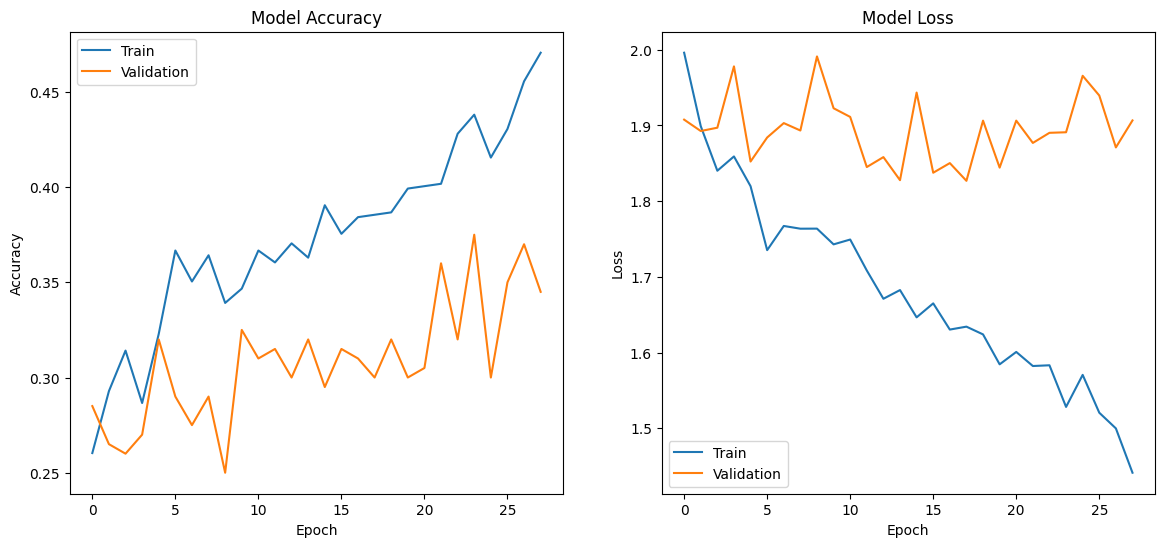

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

## Confusion Matrix

7/7 [==============================] - 4s 600ms/step


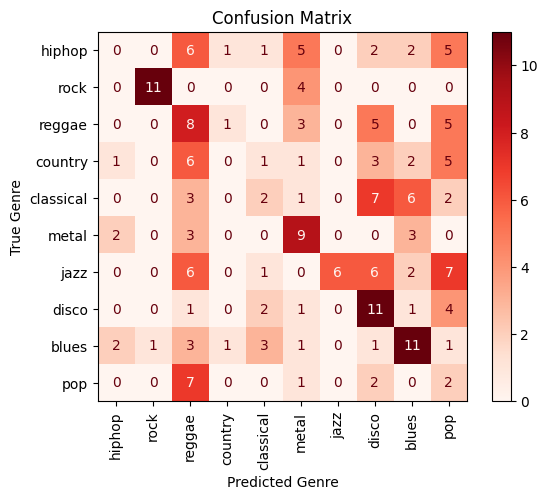

In [ ]:
# Assuming you have the model and the validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

genres = song_dct.keys()

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.show()

# EXTRA TRIALS DONE


## Grid Search to find Hyperparameters

In [ ]:
# from sklearn.model_selection import ParameterGrid
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the search space
# param_grid = {
#     'patch_size': [8, 16, 32],
#     'num_layers': [6, 8, 12],
#     'num_heads': [4, 8, 16],
#     'mlp_dim': [256, 512, 1024]
# }

# # Define early stopping and reduce LR callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, verbose=True)

# # Perform grid search
# best_accuracy = 0.0
# best_params = {}

# for params in ParameterGrid(param_grid):
#     print("Training with params:", params)

#     # Instantiate the ViT model with the specified hyperparameters
#     model = VisionTransformer(
#         image_size=224,
#         patch_size=params['patch_size'],
#         num_layers=params['num_layers'],
#         num_classes=10,
#         d_model=256,
#         num_heads=params['num_heads'],
#         mlp_dim=params['mlp_dim'],
#         channels=3,
#         dropout=0.1
#     )

#     # Compile the model with the desired optimizer, loss function, and metrics
#     optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
#     ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#     model.compile(loss=ce_loss, optimizer=optimizer, metrics=["accuracy"])

#     # Apply data augmentation
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True
#     )
#     datagen.fit(X_train)

#     # Train the model on the training data with data augmentation and evaluate on the validation data
#     history = model.fit(
#         datagen.flow(X_train, y_train, batch_size=128),
#         steps_per_epoch=len(X_train) // 128,
#         epochs=30,
#         validation_data=(X_val, y_val),
#         callbacks=[early_stopping, reduce_lr]
#     )

#     # Evaluate the model's performance
#     _, accuracy = model.evaluate(X_val, y_val)
#     print("Validation accuracy:", accuracy)

#     # Check if the current hyperparameters yielded the best accuracy so far
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_params = params

# print("Grid search completed!")
# print("Best accuracy:", best_accuracy)
# print("Best parameters:", best_params)

Training with params: {'mlp_dim': 256, 'num_heads': 4, 'num_layers': 6, 'patch_size': 8}
Epoch 1/30
